In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image as PILImage
from io import BytesIO
from IPython.display import Image, display
import requests

In [2]:
df = pd.read_csv("../memes_posts.csv")
df.head()

,title,ups,num_comments,url,created_utc,permalink
0,No game no life,1,0,https://i.redd.it/dzgrraj7yzje1.jpeg,2025-02-19 01:15:02+00:00,https://www.reddit.com/r/memes/comments/1ist0y...
1,"Tell me, did you?",5,4,https://i.redd.it/0ucn5a79wzje1.png,2025-02-19 01:03:12+00:00,https://www.reddit.com/r/memes/comments/1issrq...
2,"It's not like we have a monopoly on it, but...",12,1,https://i.redd.it/noc6vlprvzje1.jpeg,2025-02-19 01:00:37+00:00,https://www.reddit.com/r/memes/comments/1isspm...
3,What r/facepalm is beginning to actually feel ...,0,5,https://i.redd.it/sfxhb7s7vzje1.jpeg,2025-02-19 00:57:23+00:00,https://www.reddit.com/r/memes/comments/1issmy...
4,me when can connect to psn.... :-; 😔,0,0,https://v.redd.it/6d9g8lsluzje1,2025-02-19 00:54:27+00:00,https://www.reddit.com/r/memes/comments/1isskk...


In [3]:
df.describe()

,ups,num_comments
count,981.000000,981.000000
mean,1622.870540,22.386340
std,6366.220267,76.490259
min,0.000000,0.000000
25%,7.000000,1.000000
50%,30.000000,4.000000
75%,163.000000,13.000000
max,60001.000000,1641.000000


In [4]:
def remove_non_image_urls(df, url_column='url'):
    # Remove URL rows that doesn't end in any image format
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif')
    df_filtered = df[df[url_column].str.lower().str.endswith(image_extensions)]
    rows_removed = len(df) - len(df_filtered)
    return df_filtered.reset_index(drop=True), rows_removed

df, removed_count = remove_non_image_urls(df)
print(f"Removed {removed_count} rows with non-image URLs.")

Removed 51 rows with non-image URLs.


In [5]:
# Function to display resized image from URL
def display_resized_image_from_url(url, max_width=500, max_height=500):
    if url.endswith(('.jpg', '.jpeg', '.png', '.gif')):
        try:
            response = requests.get(url)
            img = PILImage.open(BytesIO(response.content))
            
            # Calculate aspect ratio
            aspect_ratio = img.width / img.height
            
            # Determine new size while maintaining aspect ratio
            if img.width > img.height:
                new_width = min(img.width, max_width)
                new_height = int(new_width / aspect_ratio)
            else:
                new_height = min(img.height, max_height)
                new_width = int(new_height * aspect_ratio)
            
            # Resize image
            img_resized = img.resize((new_width, new_height))
            
            buf = BytesIO()
            img_resized.save(buf, format='PNG')
            
            display(Image(buf.getvalue()))
        except Exception as e:
            print(f"Error displaying image: {e}")
    else:
        print("URL is not a direct link to an image.")

# Function to display image from DataFrame row
def display_image_from_df(row, max_width=500, max_height=500):
    print(f"Title: {row['title']}")
    print(f"URL: {row['url']}")
    display_resized_image_from_url(row['url'], max_width, max_height)
    print("\n")

Title: Resolve, intellect, endurance, and sheer fucking will
URL: https://i.redd.it/q95fxifexjie1.png


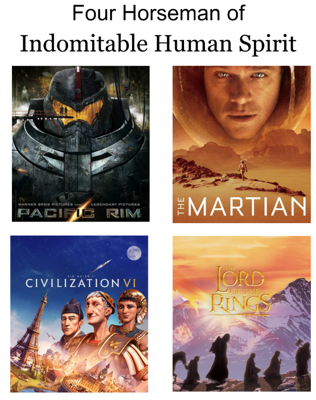



Title: Meme i made 🤣
URL: https://i.redd.it/2fjp777lvjie1.jpeg


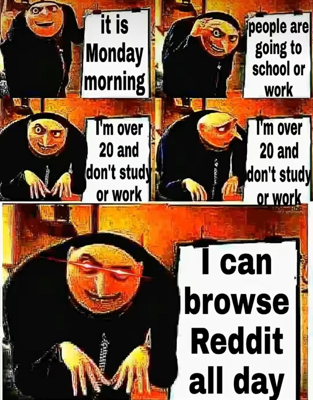



Title: Minimalist
URL: https://i.redd.it/ihyc6ezesjie1.png


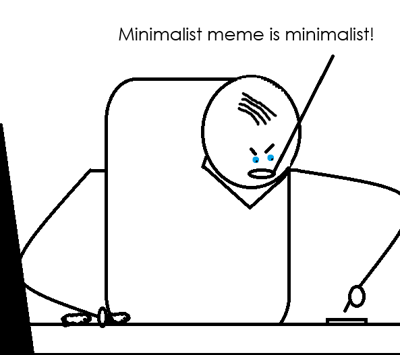



Title: Great idea
URL: https://i.redd.it/arhebpuiqjie1.jpeg


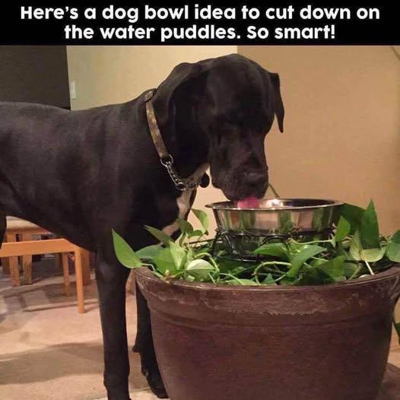



Title: It’s the fucking economy fucking genius
URL: https://i.redd.it/5jezusurljie1.jpeg


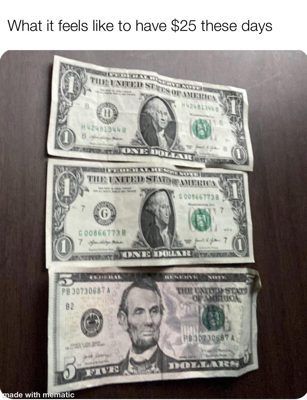

In [6]:
# Display last 5 images from the DataFrame
for _, row in df.tail().iterrows():
    display_image_from_df(row, max_width=400, max_height=400)

## Data Exploration

Text(0.5, 1.0, 'Distribution of Up-votes')

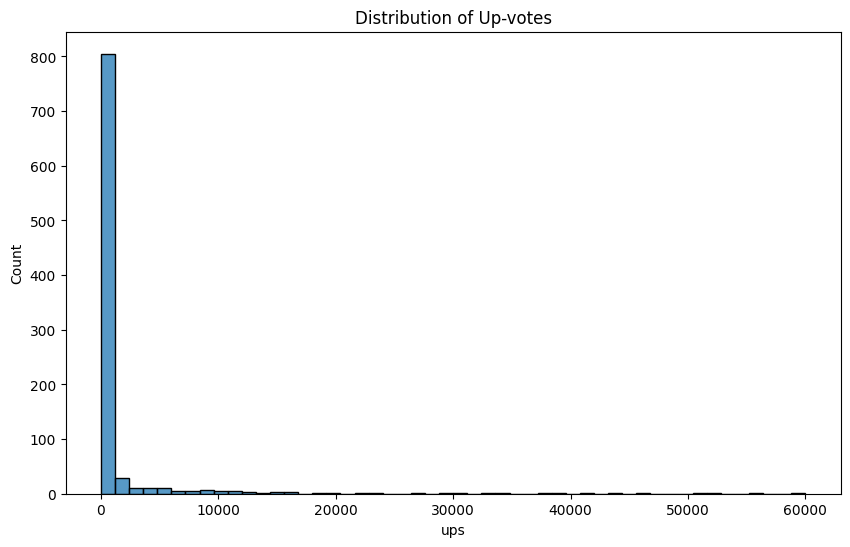

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=df, x="ups", bins=50, ax=ax)
plt.title("Distribution of Up-votes")

### Findings
The histogram shows that the majority of memes have received less than 500 up-votes. The highly right-skewed distribution of up-votes on posts in the /memes subreddit over the last 30 days reveals several important insights about meme popularity and user engagement on Reddit:
- Viral nature of memes: The long tail extending to 65,000 up-votes indicates that a small number of memes can go viral and receive exponentially more attention than the average post
- User behavior patterns: This distribution reflects how users interact with content on the platform, with most users likely browsing and up-voting a limited number of posts that appear at the top of their feed
- The subreddit itself: The number of subscribers and active users could contribute to this upvote distribution pattern

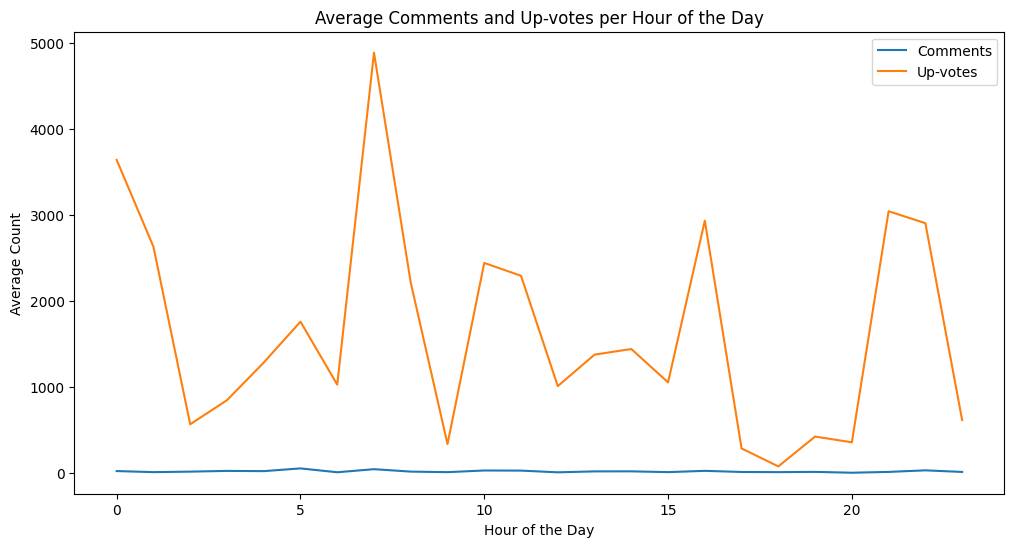

In [8]:
# Time of day for user engagement
df['local_time'] = pd.to_datetime(df['created_utc'])

df['local_time'] = df['local_time'].dt.tz_convert('US/Eastern')
df['hour'] = df['local_time'].dt.hour

hourly_stats = df.groupby('hour')[['num_comments', 'ups']].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_stats, x='hour', y='num_comments', label='Comments')
sns.lineplot(data=hourly_stats, x='hour', y='ups', label='Up-votes')
plt.title("Average Comments and Up-votes per Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Count")
plt.legend()
plt.show()

## Findings
- The line plot shows that the average number of up-votes per hour of the day on memes in the /memes subreddit seems to be unstable. The instability suggests that user engagement with memes fluctuates a lot throughout the day. 
    - This could be due to various factors like time zone differences, posting trends, or the viral nature of certain memes that get bursts of up-votes at specific times.
- The average number of comments per hour of the day seems to be stable, forming almost a straight line. 
    - This could be an implication that comments are less influenced by time of day compared to up-votes or that users are engaging in discussions at fairly steady rates across different hours.


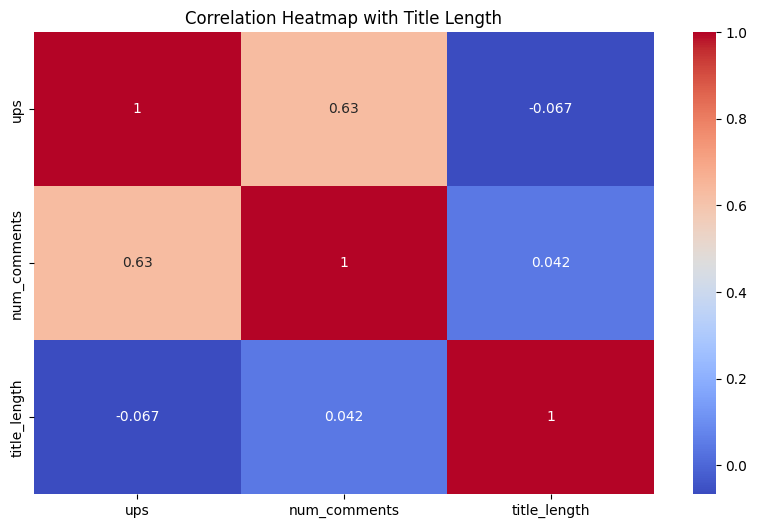

In [9]:
# Correlation between length of the title and the up-votes/comments
df['title_length'] = df['title'].apply(len)
heatmap_data = df[['ups', 'num_comments', 'title_length']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap with Title Length")
plt.show()

## Findings
- The length of the title seems to have little influence on the number of up-votes/comments, demonstrating a correlation of -0.053 and 0.042 respectively. This makes sense, as the popularity of a meme depends more on the content and humor. 
- On the other hand, the number of comments seems to be influenced to some extent by the number of up-votes, and vice versa, as indicated by a correlation of 0.67.

In [10]:
# The correlation between the semantic meanings of the title and the up-votes
from sklearn.feature_extraction.text import TfidfVectorizer 

# Create the vectorizer object
vectorizer = TfidfVectorizer(stop_words='english')

# Fit-transform the title column
title_tfidf = vectorizer.fit_transform(df['title'])

# Convert the TF-IDF scores to a DataFrame
title_tfidf_df = pd.DataFrame(title_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Calculate the correlation between the title TF-IDF scores and up-votes
correlation_matrix = title_tfidf_df.corrwith(df['ups'])

# Display the top 10 most correlated words with up-votes/comments
top_10_positive = correlation_matrix.sort_values(ascending=False).head(10)

print("Top 10 most correlated words with up-votes:")
print(top_10_positive)

Top 10 most correlated words with up-votes:
terrible            0.275507
choices             0.258605
duolingo            0.243787
terraria            0.227687
female              0.227687
character           0.227687
killed              0.225935
tough               0.224635
misunderstanding    0.189357
creatures           0.181147
dtype: float64


## Findings
- The top words like "college," "terrible," and "duolingo" likely reflect popular topics that resonate with the audience, possibly indicating their age range. 
- The highest correlation of 0.32 suggests that while title semantics play a role, other factors are more influential in driving engagement.
    - For example, the time of posting, meme format, and even external trends could all play significant roles in how a meme performs.
- The correlation of title semantics and the number of up-votes could be taken into account when it comes to determining the popularity of a group of memes.

## Conclusions
By combining image captioning with semantic analysis of meme titles, we can extract both visual and textual features to determine meme popularity.

- Image Semantics: OpenCV/AWS AI services can identify key visual elements (e.g., "dog" and "speak" in a meme of a dog talking), providing a semantic description of the image.
- Text Semantics: Semantic analysis of meme titles reveals which words or topics resonate with users (e.g., "dog," "terrible," "duolingo").

Multi-Modal Analysis: By combining image captions and title semantics, we can assess how both text and visual elements contribute to meme engagement (up-votes/comments).

## Next Step
Preparing data for image processing (CNNs):
- Resize images to a fixed size.
- Extract relevant features from images using pre-trained models like VGG16 or ResNet50.
- Combine the extracted features with title semantics for better understanding of meme popularity.

For AWS:
- Extract sample of image URLs.
- Save sample images locally for AWS analysis.
- Prepare data structure for AWS ML image processing results.
- Set up a popularity metric by combining the extracted features with title semantics.
